# Finding group anomalies

What do we want? To find groups of data-points that are anomalous, i.e. different from the rest, but are similar to each other. Individual data-points that are weird may be just glitches, a group of points that differ from the others in a systematic way while being similar to each other is more interesting. An obvious application are *stellar streams* (for Claudia's thesis) but clearly we can go beyond that. We touched on this when talking with Siamak, Vassilli, etc...

Below I introduce a new approach with respect to what we tried so far, which was basically clustering with out-of-the-box tools. _The key step that is missing is validating this with actual known stellar streams. Giuliano will help us with that next week_.
Additionally, the following is based on Claudia's selection of stars and integral-of-motion calculations, which we should double check.


### Topological data analysis

Directly clustering or doing anomaly detection with e.g. [isolation forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) may or may not give us what we want. It ends up being a game where you fiddle endlessly with hyperparameters until you give up (even though it's not a bad idea to explore a bit per se - open ended play and all that).

Anyway, I stumbled upon something that may do better: [topological data analysis](https://www.quantmetry.com/blog/topological-data-analysis-with-mapper/). There is already a [package](https://scikit-tda.org). Detailed theory [here](https://arxiv.org/pdf/1904.11044.pdf). Crucially, I talked about this with Kolya for $\approx 10$ minutes at the café in MILA and he was excited about it, mainly because topology is good. 

A picture is worth $10^3$ words:
![mapper](mapper.png)

This is the mapper algorithm. It's local clustering, in a sense. And it preserves the topological properties (e.g. holes) of the clusters it finds. Local clustering is important to us if we want to find structures that are _more densely clustered together than the background_. This is something that does not happen if we used e.g. DBSCAN right away: _eps_ and _min_samples_ set a density threshold once and for all for the whole dataset.

Anyway let's unpack this step by step:

* You start from some high dimensional feature space (Claudia's integrals of motion are far from high dimensional, but they will do to illustrate the process; we might throw in other variables later).
* You apply a function that sends this space into one (or two, or n with small n) dimensions. It does not have to be any particular function, you can choose it as you like. We call it the _lens_. In the picture above it's just projecting to one coordinate.
* You cover the low dimensional space with overlapping boxes (intervals if it's 1D)
* You look at the points in the high dimensional space that got sent to any given box (the pre-image of the box), and cluster them with you favourite clustering algorithm
* Every cluster becomes a node in a graph
* Nodes corresponding to clusters from different boxes that share at least one point (remember that the boxes overlap) get linked to each other
* You obtained a graph that shares some topological properties with the original high dimensional data
* We can now play with the graph

In particular each node of the graph corresponds to a cluster of points that share the same value of the lens. If the lens is an isolation forest score, then these are levels of isolatedness. That word does not exist, so let's say density. The graph may have more than one connected component. A connected component of the graph with a limited number of stars in it is a candidate for a group anomaly.

In [1]:
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import kmapper as km
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from kmapper.jupyter import display
from sklearn.ensemble import IsolationForest
import pandas as pd
from sklearn.preprocessing import RobustScaler
from networkx import adjacency_matrix
from sknetwork.topology import get_connected_components

#to make a scikit-learn compatible classifier class, following here https://scikit-learn.org/stable/developers/develop.html
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.neighbors import NearestNeighbors

Let's read and scale the integral of motion data (pre-selected and pre-computed by Claudia). These are the energy, the angular momentum along the $z$ axis, the total angular momentum, and circularity.

In [2]:
rs = RobustScaler()
ELzLT = pd.read_csv('E_Lz_LT_circ.csv', header = None)
X = ELzLT.transpose()
X = rs.fit_transform(X)

In the following we will need to choose a clustering method to apply to the pre-images of the intervals that cover the image of our dataset thorugh the lens. Since each pre-image corresponds to a range in density (because the lens is the isolation forest score) we want to apply DBSCAN with _eps_ and _min_samples_ adequate to that level of the density. If we just pass a DBSCAN instance to the mapper (see below) we will not have this, because _eps_ and _min_samples_ will be set once an for all. So I create a new classifier, which is just a wrapper to DBSCAN, that runs DBSCAN with an _eps_ that is a multiple of the minimum nearest neighbor distance, while I leave _min_samples_fixed_. We can tune this later on to see what happens.

In [3]:
class CustomDBSCAN(BaseEstimator, ClassifierMixin):

    def __init__(self, demo_param='demo'):
         self.demo_param = demo_param

    def fit(self, X, y=None):
        self.X_ = X
        return self

    def fit_predict(self, X):
        self.fit(X)
        check_is_fitted(self)
        X = check_array(X)
        neigh = NearestNeighbors(n_neighbors=2, radius=100)
        neigh.fit(X)
        k = 8.0
        eps = k*neigh.kneighbors(X, 2, return_distance=True)[0][:,1].min() #set epsilon based on the local density of the data; k times the min distance of nearest neighbor
        min_samples = 4 #1+int(0.1*X.shape[0])
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        return dbscan.fit_predict(X)        

In [4]:
tc = CustomDBSCAN()
tc.fit_predict(X).max()

-1

Interestingly, this custom version of DBSCAN applied to the whole dataset finds no clusters ($-1$ represents noise points in the output of the predict method from DBSCAN). This is not an issue, because the minimum nearest neighbor distance on the whole dataset is, well... very small.

Now let's finally apply the mapper algorithm (in its KeplerMapper implementation) to our data.

In [5]:
def kmapper_gaia(d, n_cubes=50, isolation_forest_n_estimators = 1000, visualize_in_notebook = False, verbose=3):
    mapper = km.KeplerMapper(verbose=verbose) #verbosity = 3 means see all
    if isinstance(d, pd.DataFrame):
        data = d.to_numpy()
    else:
        data = d
    isof = IsolationForest(random_state=888, n_estimators=isolation_forest_n_estimators).fit(data) 
    isoscore = isof.score_samples(data)
    cover = km.Cover(n_cubes=n_cubes)
    graph = mapper.map(isoscore, data, cover=cover, clusterer=CustomDBSCAN()) #use our custom DBSCAN
    _ = mapper.visualize(graph, path_html="keplermapper_output.html",
                 title="Gaia")
    if (visualize_in_notebook):
        display("keplermapper_output.html") #visualize the graph directly in the notebook; it's ugly
    return graph, isoscore

graph, isoscore = kmapper_gaia(X)

KeplerMapper(verbose=3)
Mapping on data shaped (48879, 4) using lens shaped (48879,)

Minimal points in hypercube before clustering: 2
Creating 50 hypercubes.
   > Found 1 clusters in hypercube 0.
   > Found 2 clusters in hypercube 1.
   > Found 2 clusters in hypercube 2.
   > Found 3 clusters in hypercube 3.
   > Found 1 clusters in hypercube 4.
   > Found 0 clusters in hypercube 5.
   > Found 0 clusters in hypercube 6.
   > Found 3 clusters in hypercube 7.
   > Found 3 clusters in hypercube 8.
   > Found 4 clusters in hypercube 9.
   > Found 1 clusters in hypercube 10.
   > Found 3 clusters in hypercube 11.
   > Found 4 clusters in hypercube 12.
   > Found 5 clusters in hypercube 13.
   > Found 8 clusters in hypercube 14.
   > Found 4 clusters in hypercube 15.
   > Found 7 clusters in hypercube 16.
   > Found 5 clusters in hypercube 17.
   > Found 6 clusters in hypercube 18.
   > Found 6 clusters in hypercube 19.
   > Found 0 clusters in hypercube 20.
   > Found 0 clusters in hypercu

Now we take the graph from the mapper and find the connected components. For each node we then take the corresponding stars and pool them all together. So the stars corresponding to nodes in each connected component are selected as our group anomalies. These do not include all the stars in the graph because a large fraction of the stars is lost by being labelled a noise point by DBSCAN. This is intended behavior. 

/var/folders/8w/66mbmptd4ws3j45r5hp0c6w80000gn/T/ipykernel_1182/1872600496.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  am_iso = adjacency_matrix(nx_graph_iso)


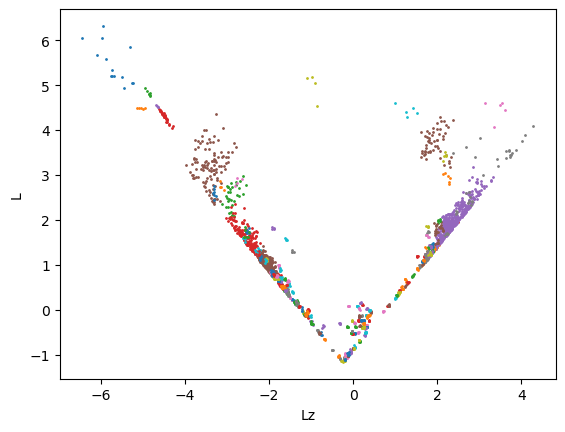

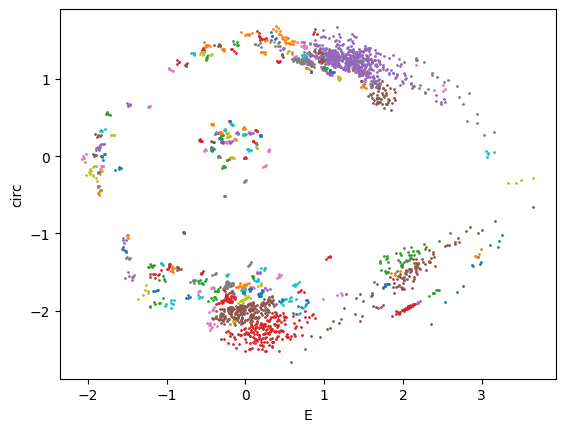

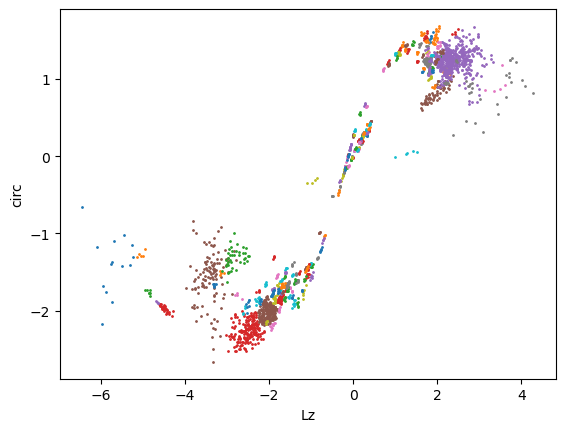

In [6]:
nx_graph_iso = km.adapter.to_nx(graph)
am_iso = adjacency_matrix(nx_graph_iso)
labels_iso = get_connected_components(am_iso)
labels_iso

for j in range(4):
    for h in range(j):
        for i in range(labels_iso.max()+1):
            cc = np.unique(np.concatenate([np.array(list(graph['nodes'].values())[k])
                                  for k in np.arange(len(labels_iso))[labels_iso==i]], axis=0))
            plt.scatter(X[cc,h], X[cc,j], s = 1)
            plt.xlabel(["E", "Lz", "L", "circ"][h])
            plt.ylabel(["E", "Lz", "L", "circ"][j])
        plt.show()


## The groups look good. We should check them against known streams.

This is where Giuliano will help us.

## What to do next?

I see two possibilities:
* Scenario 1: most of the groups do in fact correspond to known or otherwise plausible streams. Some of them might be a single-burst stellar population (disrupted star clusters) and we can check that with color-magnitude diagrams. In that case **I believe this would be a publishable result** and we should start writing.
* Scenario 2: the groups do not really correspond to actual stream, at least not more so than the output of a simple clustering algorithm (OPTICS, Agglomerative clustering with Ward linkage...). In this case **while this would probably not be a publishable result we can write a research note (RNAAS) or something of the sort**.

### Appendix: visualizing the isolation forest score

The isolation forest score depends on how many random stumps were needed to isolate a point. This is related to how densely packed with points any given region of feature space is. You should easily see that this score is not useful, per se, for finding group anomalies, except perhaps in the most obvious cases.


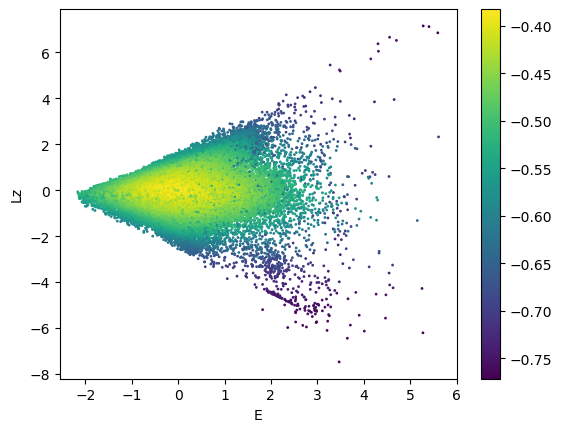

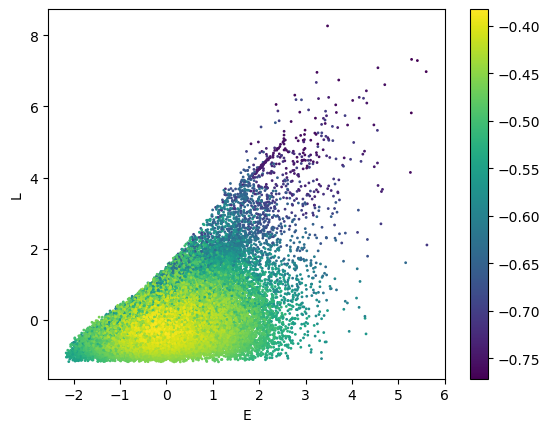

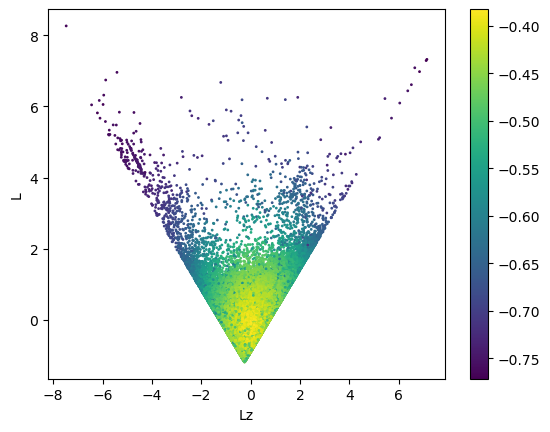

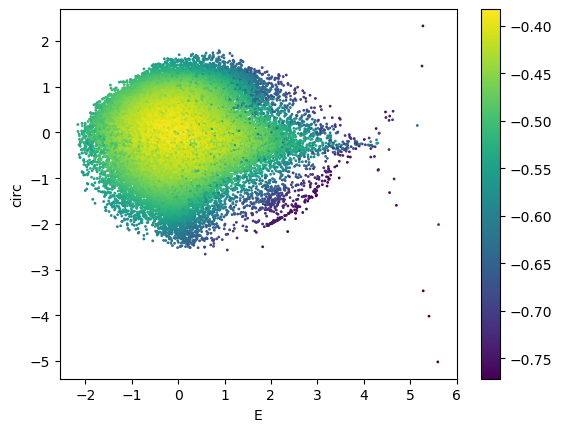

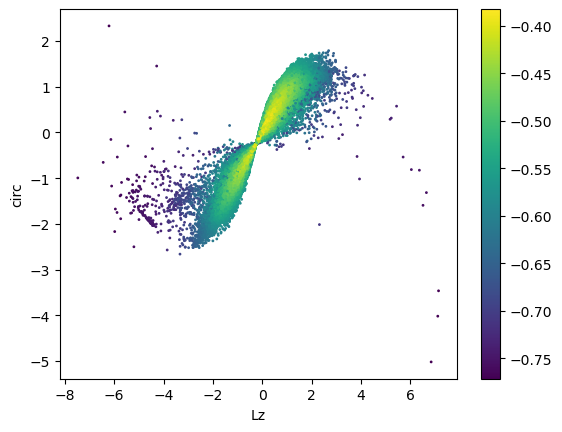

In [7]:
for j in range(4):
    for h in range(j):
        plt.scatter(X[:,h], X[:,j], s = 1, c=isoscore)
        plt.xlabel(["E", "Lz", "L", "circ"][h])
        plt.ylabel(["E", "Lz", "L", "circ"][j])
        plt.colorbar()
        plt.show()

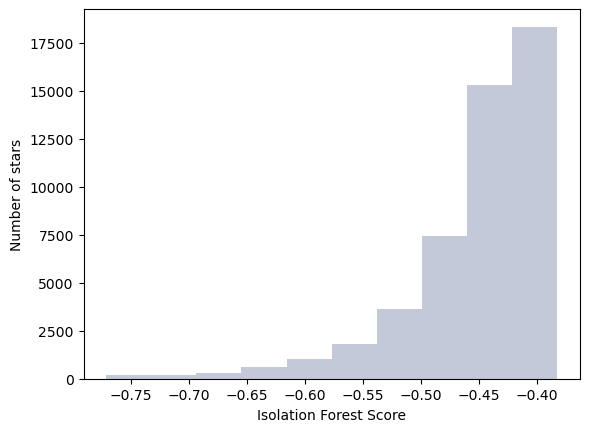

In [8]:
plt.hist(isoscore, color = "#C3C9D9")
plt.xlabel("Isolation Forest Score")
plt.ylabel("Number of stars")
plt.show()